In [1]:
import numpy as np
import tcbench as tcb
import faiss
import matplotlib.pyplot as plt

In [2]:
vectors_baseline = np.load('artifacts-mirage19/baseline_vectors.npy')
labels_baseline = np.load('artifacts-mirage19/baseline_labels.npy')

vectors_embeddings = np.load('artifacts-mirage19/embeddings_vectors.npy')
labels_embeddings = np.load('artifacts-mirage19/embeddings_labels.npy')

In [3]:
df_split = tcb.load_parquet(tcb.DATASETS.MIRAGE19, min_pkts=10, split=True)
train_val_indices = np.concatenate([df_split.iloc[0][0], df_split.iloc[0][1]])
test_indices = df_split.iloc[0][2]

In [4]:
def build_faiss_index(data, labels, train_indices, distance_type, samples_per_class):
    np.random.seed(42)

    filtered_data = data[train_indices]
    filtered_labels = labels[train_indices]
    d = filtered_data.shape[1]

    selected_data = []
    selected_indices = []
    unique_labels = np.unique(filtered_labels)
    for label in unique_labels:
        label_indices = np.where(filtered_labels == label)[0]
        if samples_per_class is None or samples_per_class == -1:
            selected_label_indices = label_indices
        else:
            selected_label_indices = np.random.choice(label_indices, size=min(samples_per_class, len(label_indices)), replace=False)
        selected_data.append(filtered_data[selected_label_indices])
        selected_indices.extend(train_indices[selected_label_indices])
    selected_data = np.vstack(selected_data)
    selected_indices = np.array(selected_indices)

    if distance_type == 'euclidean':
        index = faiss.IndexFlatL2(d)
    elif distance_type == 'cosine':
        norms = np.linalg.norm(selected_data, axis=1, keepdims=True)
        selected_data = selected_data / norms
        index = faiss.IndexFlatIP(d)
    else:
        raise ValueError("Unsupported distance type. Use 'euclidean' or 'cosine'.")

    index.add(selected_data)
    return index, selected_indices

In [5]:
def search_and_compare_labels(data, labels, test_indices, selected_indices, index, metric, limit=None):
    k = 1    
    D, I = index.search(data[test_indices], k)
    test_labels = labels[test_indices]
    neighbor_labels = labels[selected_indices[I.flatten()]].reshape(I.shape)

    top_1_matches = 0
    classified_count = 0

    for i in range(len(test_labels)):
        if limit is not None:
            if metric=="distance" and np.sqrt(D[i, 0]) > limit:
                continue
            if metric=="similarity" and D[i, 0] < limit:
                continue

        classified_count += 1
        top_1_match = test_labels[i] in neighbor_labels[i, :1]

        if top_1_match:
            top_1_matches += 1

    if classified_count > 0:
        top_1_percentage = (top_1_matches / classified_count) * 100
    else:
        top_1_percentage = 0
    classified_percentage = (classified_count / len(test_labels)) * 100

    return classified_percentage, top_1_percentage

In [6]:
def extract_results(vectors, labels, train_indices, test_indices, distance_type, metric, samples, limits):
    classified_results = {li: [] for li in limits}
    accuracy_results = {li: [] for li in limits}

    for limit in limits:
        for sample_size in samples:
            index, selected_indices = build_faiss_index(
                vectors, labels, train_indices, distance_type, sample_size
            )
            classified, accuracy = search_and_compare_labels(
                vectors, labels, test_indices, selected_indices, index, metric, limit
            )
            classified_results[limit].append(classified)
            accuracy_results[limit].append(accuracy)   
    return classified_results, accuracy_results

In [7]:
def plot_results(classified_results, accuracy_results, samples, distances):
    num_distances = len(distances)
    fig, axes = plt.subplots((num_distances + 1) // 2, 2, figsize=(12, 4 * ((num_distances + 1) // 2)), sharex=True)

    axes = axes.flatten()

    for i, distance in enumerate(distances):
        ax = axes[i]
        
        ax.plot(samples, accuracy_results[distance], label='Accuracy', color='blue')
        ax.set_xlabel('Number of Samples Per Class') 
        ax.set_ylabel('Accuracy (%)', color='blue')   
        ax.tick_params(axis='y', labelcolor='blue')
        ax.set_ylim(0, 100)
        ax.set_title(f'Distance: {distance}')
        ax.grid(True)
        
        ax2 = ax.twinx()
        ax2.plot(samples, classified_results[distance], label='Classified %', color='green', linestyle='--')
        ax2.set_xlabel('Number of Samples Per Class')
        ax2.set_ylabel('Classified Percentage (%)', color='green')
        ax2.set_ylim(0, 100)
        ax2.tick_params(axis='y', labelcolor='green')
        
        # # Add legends
        # ax.legend(loc='upper left')
        # ax2.legend(loc='upper right')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

In [ ]:
samples = [5,10,20,30,40,50,60,70,80,90,100,200,300,400,
            500,600,700,800,900,1000,2000,3000,4000,5000]

distances_baseline = [0.005, 0.01, 0.05, 0.1]
distances_embeddings = [0.1, 0.5, 1, 5]
similarities = [0.9, 0.95, 0.99, 0.995]

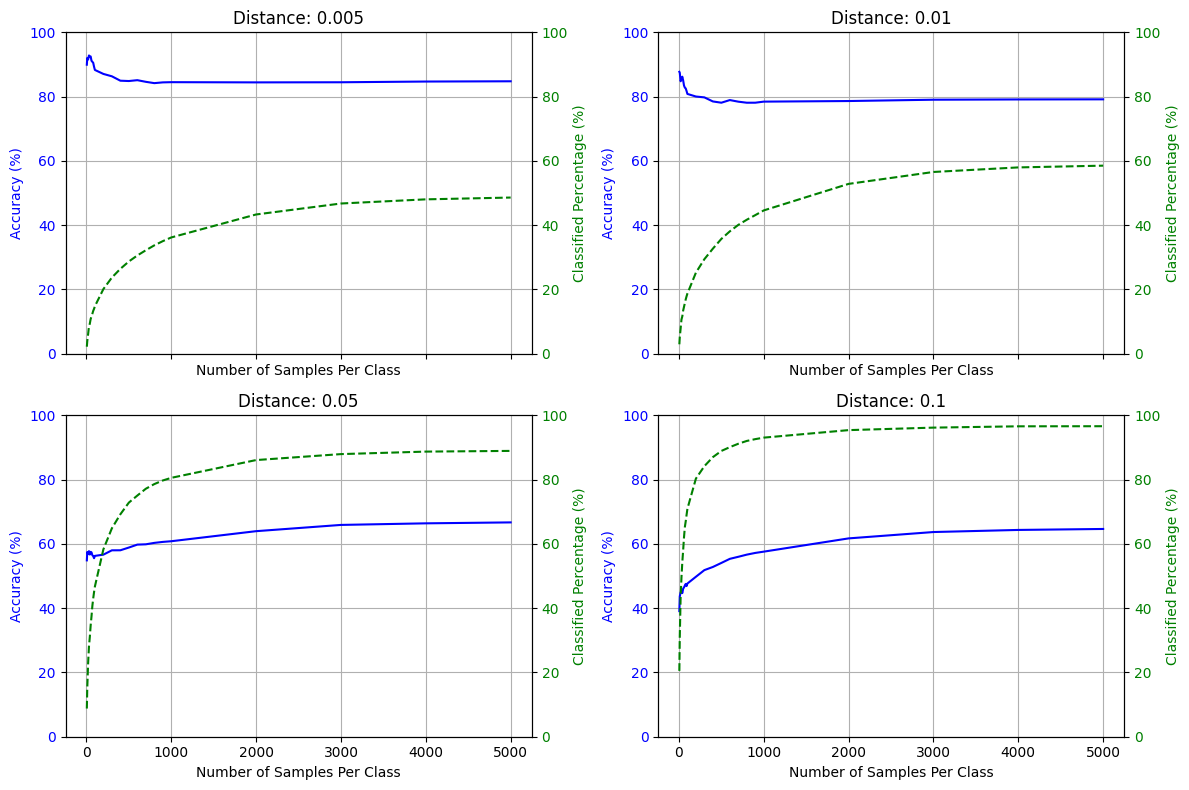

In [121]:
classified_results_baseline, accuracy_results_baseline = extract_results(vectors_baseline, labels_baseline, train_val_indices, test_indices, 'euclidean', 'distance', samples, distances_baseline)
plot_results(classified_results_baseline, accuracy_results_baseline, samples, distances_baseline)

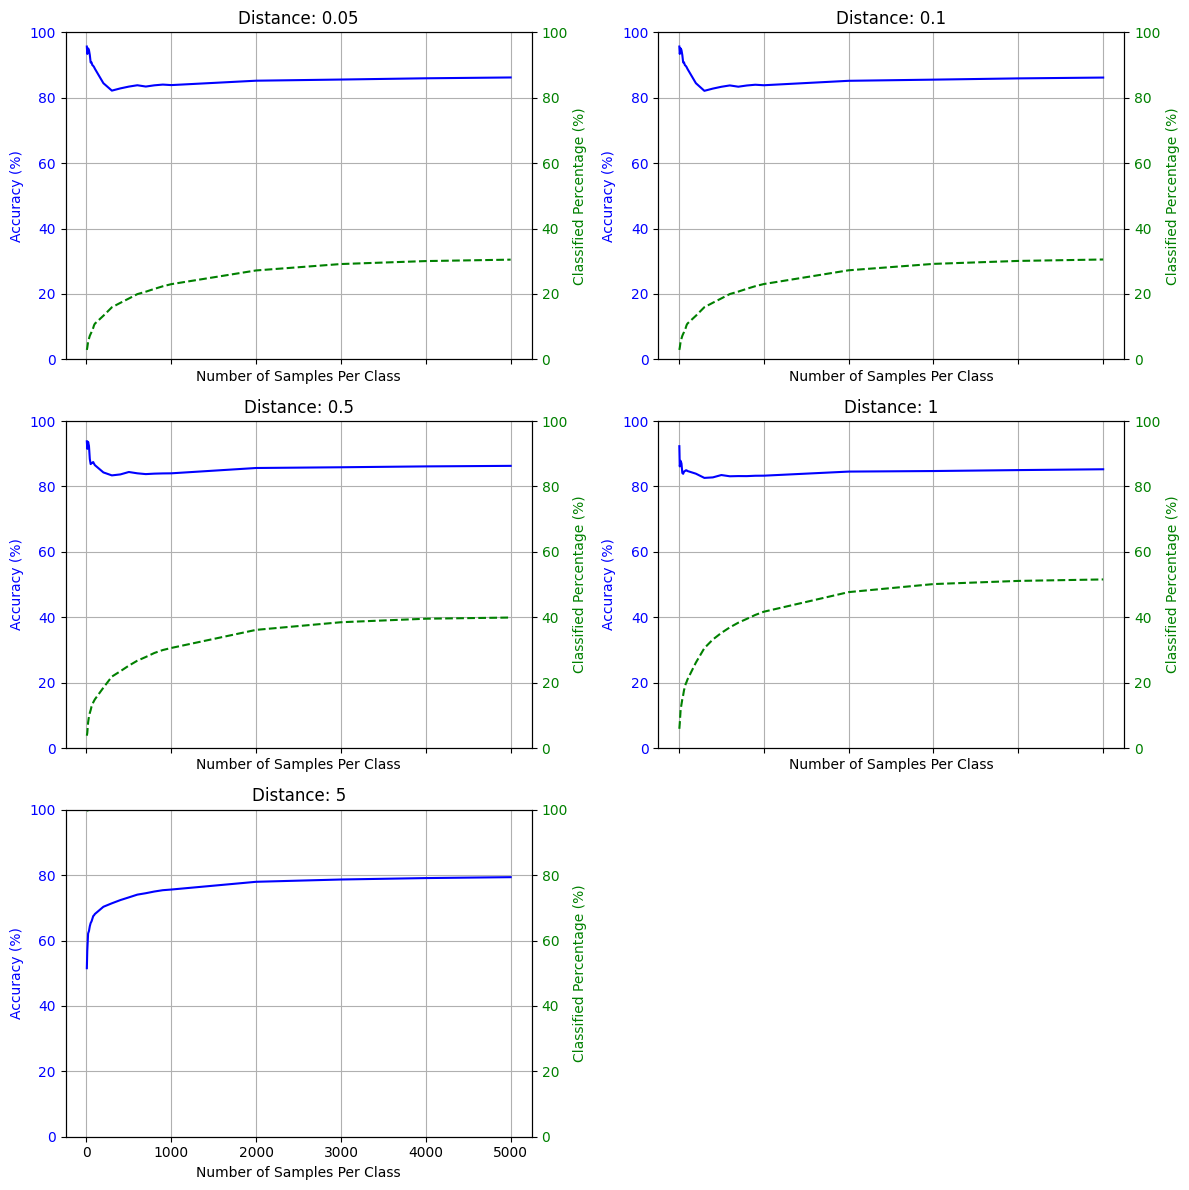

In [124]:
classified_results_embeddings, accuracy_results_embeddings = extract_results(vectors_embeddings, labels_embeddings, train_val_indices, test_indices, 'euclidean', 'distance', samples, distances_embeddings)
plot_results(classified_results_embeddings, accuracy_results_embeddings, samples, distances_embeddings)

In [24]:
classified_results_embeddings_cosine, accuracy_results_embeddings_cosine = extract_results(vectors_embeddings, labels_embeddings, train_val_indices, test_indices, 'cosine', 'similarity', samples, similarities)
plot_results(classified_results_embeddings_cosine, accuracy_results_embeddings_cosine, samples, similarities)

Embeddings euclidean classified percentage: 100.00%
Embeddings euclidean match in top neighbor: 79.39%
